In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import plot_tree
from dotenv import load_dotenv
import random
import os

# Importing Packages

In [2]:
load_dotenv()

reference_dir = os.getenv("reference_dir")
pricing_results_dir = os.getenv("pricing_results_dir")

dataco = pd.read_csv(os.path.join(reference_dir, "dataco.csv"))

df_prep = pd.read_csv(os.path.join(reference_dir, "dataco_prepped.csv"))

merged_prep = pd.read_csv(os.path.join(reference_dir, "dataco_olist_prepped.csv"))


# sklearn DT with dataco only

In [7]:

X = df_prep.drop(columns=['Final Price'])
y = df_prep['Final Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
sklearn_model = DecisionTreeRegressor(max_depth=4, random_state=42)
sklearn_model.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred = sklearn_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
print(f"Mean Absolute Error: {mae}")

Mean Absolute Percentage Error (MAPE): 35.65%
Mean Absolute Error: 20.329779370711382


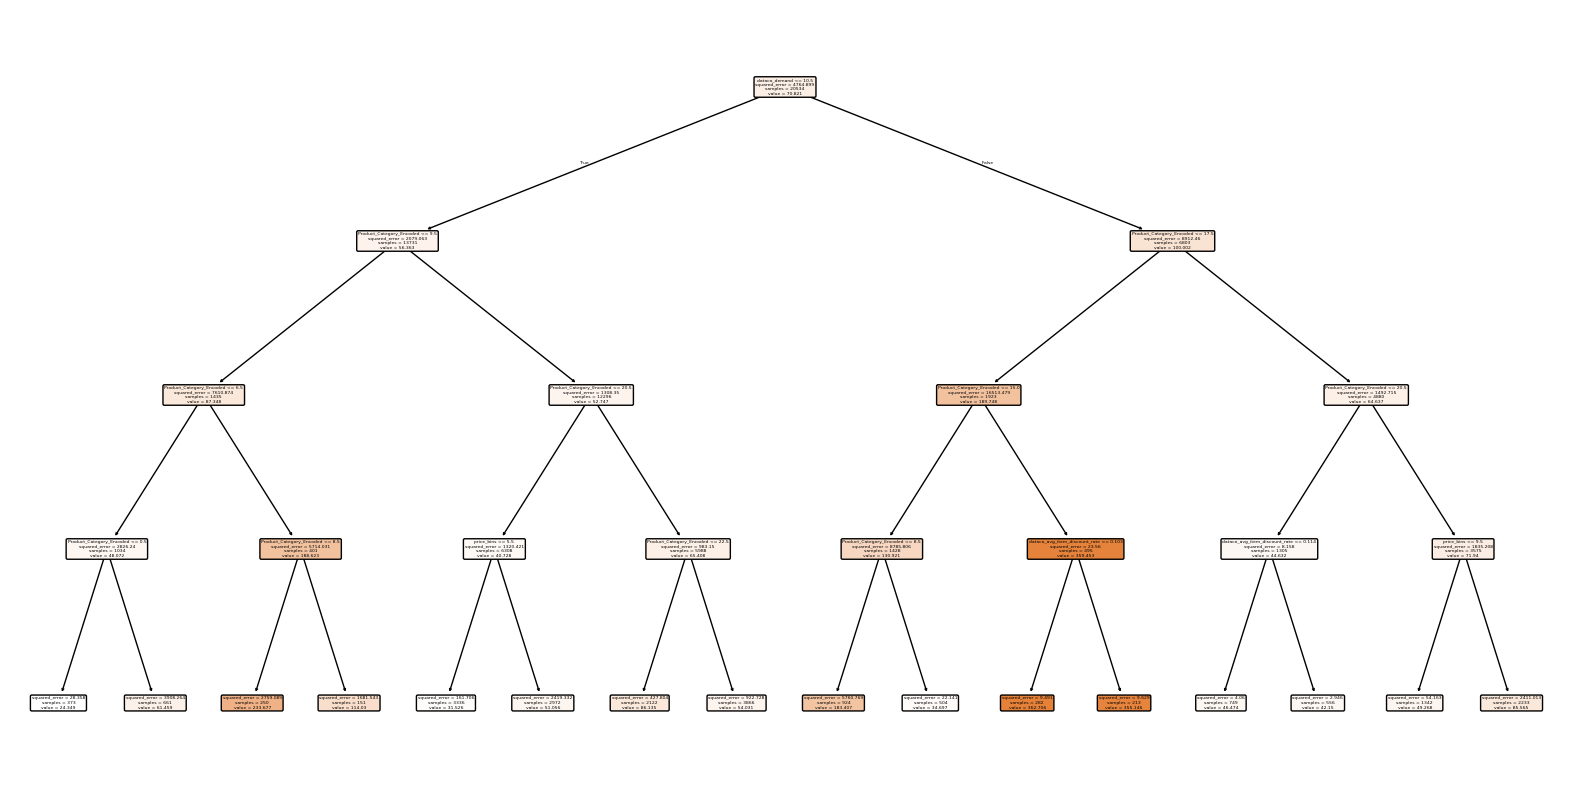

In [8]:
# Assuming 'model' is your trained decision tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed for better readability
plot_tree(
    sklearn_model,
    feature_names=X_train.columns,  # Use the column names from your training set
    class_names=True,               # If it's a classifier, you can show class names
    filled=True,                    # Color nodes to show majority class
    rounded=True                    # Rounded boxes for nodes
)
plt.show()

In [9]:
df_prep.columns

Index(['price_bins', 'dataco_avg_item_discount_rate', 'dataco_demand',
       'Final Price', 'Seasonality_Holiday - Christmas',
       'Seasonality_Holiday - Cyber Monday', 'Seasonality_Regular',
       'Seasonality_Seasonal - Back to School',
       'Seasonality_Seasonal - Summer Sales', 'price_elasticity_Inelastic',
       'Product_Category_Encoded'],
      dtype='object')

# sklearn DT with dataco + competitor

In [10]:

X = merged_prep.drop(columns=['Final Price'])
y = merged_prep['Final Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
sklearn_model = DecisionTreeRegressor(max_depth=4, random_state=42)
sklearn_model.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred = sklearn_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape:.2%}")
print(f"Mean Absolute Error: {mae}")


Mean Absolute Percentage Error: 35.65%
Mean Absolute Error: 20.32977937071141


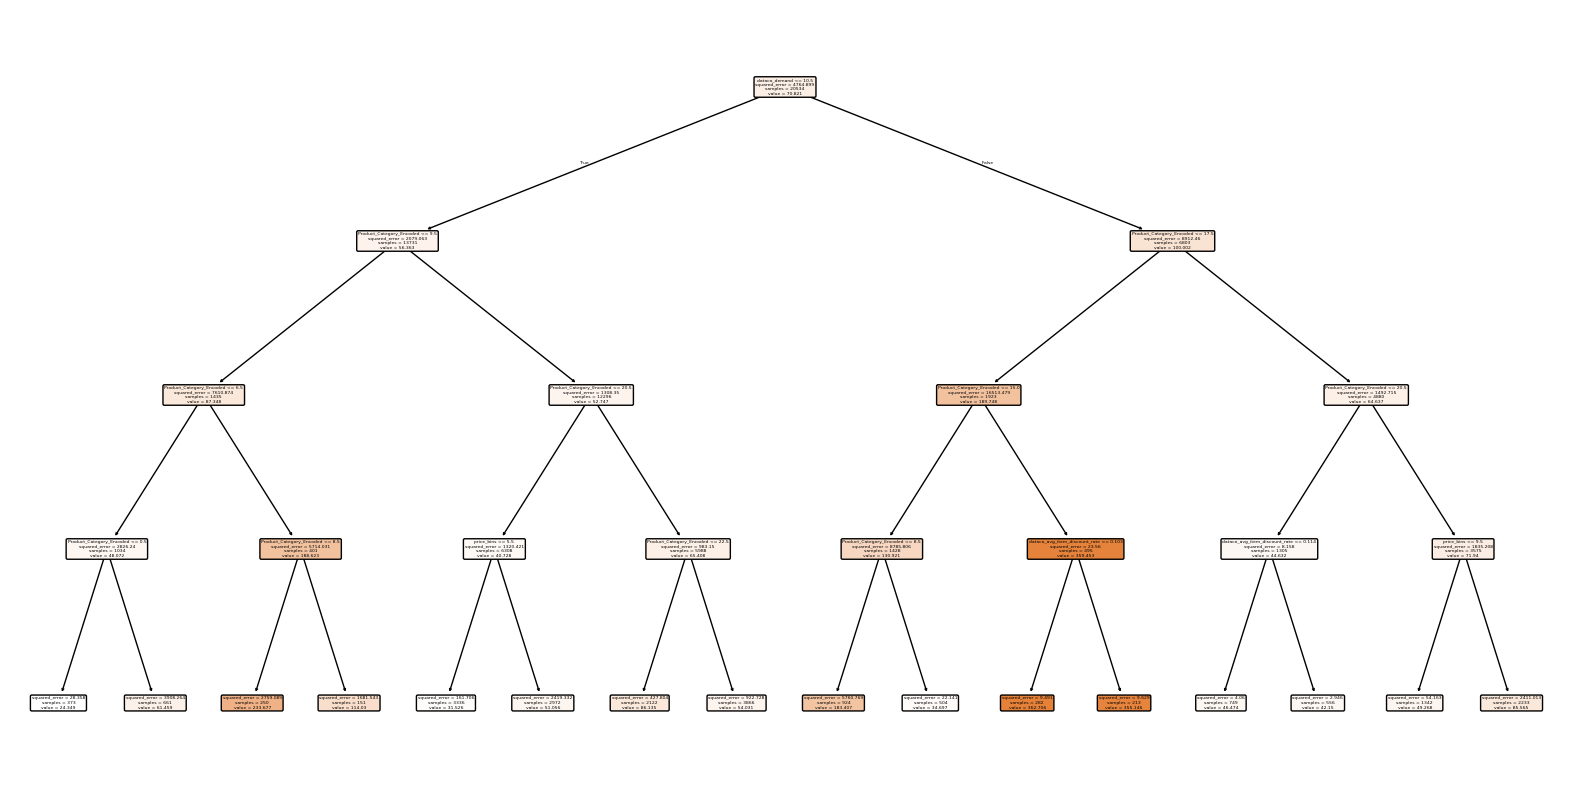

In [11]:
# Assuming 'model' is your trained decision tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed for better readability
plot_tree(
    sklearn_model,
    feature_names=X_train.columns,  # Use the column names from your training set
    class_names=True,               # If it's a classifier, you can show class names
    filled=True,                    # Color nodes to show majority class
    rounded=True                    # Rounded boxes for nodes
)
plt.show()

In [12]:
X_test.columns

Index(['price_bins', 'dataco_avg_item_discount_rate', 'dataco_demand',
       'olist_product_demand', 'olist_price_before_discount',
       'olist_avg_discount_rate', 'Product_Category_Encoded',
       'Seasonality_Holiday - Christmas', 'Seasonality_Holiday - Cyber Monday',
       'Seasonality_Regular', 'Seasonality_Seasonal - Back to School',
       'Seasonality_Seasonal - Summer Sales', 'price_elasticity_Elastic',
       'price_elasticity_Inelastic'],
      dtype='object')

# Attempt at implementation of DT

In [13]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

class DecisionTreeRegressor_2():
    def __init__(self, min_samples_split=2, max_depth=5):
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

# Implemented DT with dataco only

In [14]:
df_prep

,price_bins,dataco_avg_item_discount_rate,dataco_demand,Final Price,Seasonality_Holiday - Christmas,Seasonality_Holiday - Cyber Monday,Seasonality_Regular,Seasonality_Seasonal - Back to School,Seasonality_Seasonal - Summer Sales,price_elasticity_Inelastic,Product_Category_Encoded
0,0,0.07,1,20.46,False,False,True,False,False,True,0
1,0,0.06,1,20.79,False,False,True,False,False,True,0
2,0,0.05,1,20.90,False,False,True,False,False,True,0
3,0,0.17,1,20.74,False,False,True,False,False,True,0
4,0,0.13,1,19.14,False,False,True,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...
25663,7,0.03,3,19.39,False,False,True,False,False,False,30
25664,7,0.25,3,14.99,False,False,True,False,False,False,30
25665,14,0.10,5,17.99,True,False,False,False,False,False,30
25666,14,0.07,5,18.59,True,False,False,False,False,False,30


In [15]:
final_price_col = df_prep.pop('Final Price')
df_prep['Final Price'] = final_price_col

X = df_prep.iloc[:, :-1].values
y = df_prep.iloc[:, -1].values.reshape(-1,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
implemented_model = DecisionTreeRegressor_2(max_depth=4)
implemented_model.fit(X_train, y_train)

# Predict with implemented DT
y_pred = implemented_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape:.2%}")
print(f"Mean Absolute Error: {mae}")

Mean Absolute Percentage Error: 26.28%
Mean Absolute Error: 11.821268068999492


In [16]:
df_prep.columns

Index(['price_bins', 'dataco_avg_item_discount_rate', 'dataco_demand',
       'Seasonality_Holiday - Christmas', 'Seasonality_Holiday - Cyber Monday',
       'Seasonality_Regular', 'Seasonality_Seasonal - Back to School',
       'Seasonality_Seasonal - Summer Sales', 'price_elasticity_Inelastic',
       'Product_Category_Encoded', 'Final Price'],
      dtype='object')

# Implemented DT with dataco + competitor

In [17]:
final_price_col = merged_prep.pop('Final Price')
merged_prep['Final Price'] = final_price_col

X = merged_prep.iloc[:, :-1].values
y = merged_prep.iloc[:, -1].values.reshape(-1,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
implemented_model = DecisionTreeRegressor_2(max_depth=4)
implemented_model.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred = implemented_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape:.2%}")
print(f"Mean Absolute Error: {mae}")


Mean Absolute Percentage Error: 26.28%
Mean Absolute Error: 11.821268068999492


In [18]:
merged_prep.columns

Index(['price_bins', 'dataco_avg_item_discount_rate', 'dataco_demand',
       'olist_product_demand', 'olist_price_before_discount',
       'olist_avg_discount_rate', 'Product_Category_Encoded',
       'Seasonality_Holiday - Christmas', 'Seasonality_Holiday - Cyber Monday',
       'Seasonality_Regular', 'Seasonality_Seasonal - Back to School',
       'Seasonality_Seasonal - Summer Sales', 'price_elasticity_Elastic',
       'price_elasticity_Inelastic', 'Final Price'],
      dtype='object')

# Analysis + Test Cases

For proof of concept and for the sake of interpretability, we will use the sklearn model (with the merged dataco and olist dataset) and decision tree plot for our analyses.

In [19]:
merged_prep

,price_bins,dataco_avg_item_discount_rate,dataco_demand,olist_product_demand,olist_price_before_discount,olist_avg_discount_rate,Product_Category_Encoded,Seasonality_Holiday - Christmas,Seasonality_Holiday - Cyber Monday,Seasonality_Regular,Seasonality_Seasonal - Back to School,Seasonality_Seasonal - Summer Sales,price_elasticity_Elastic,price_elasticity_Inelastic,Final Price
0,0,0.07,1,0.0,0.0,0.0,0,False,False,True,False,False,False,True,20.46
1,0,0.06,1,0.0,0.0,0.0,0,False,False,True,False,False,False,True,20.79
2,0,0.05,1,0.0,0.0,0.0,0,False,False,True,False,False,False,True,20.90
3,0,0.17,1,0.0,0.0,0.0,0,False,False,True,False,False,False,True,20.74
4,0,0.13,1,0.0,0.0,0.0,0,False,False,True,False,False,False,True,19.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25663,7,0.03,3,0.0,0.0,0.0,30,False,False,True,False,False,True,False,19.39
25664,7,0.25,3,0.0,0.0,0.0,30,False,False,True,False,False,True,False,14.99
25665,14,0.10,5,0.0,0.0,0.0,30,True,False,False,False,False,True,False,17.99
25666,14,0.07,5,0.0,0.0,0.0,30,True,False,False,False,False,True,False,18.59


In [20]:
X = merged_prep.drop(columns=['Final Price'])
y = merged_prep['Final Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
sklearn_model = DecisionTreeRegressor(max_depth=4, random_state=42)
sklearn_model.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred = sklearn_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape:.2%}")
print(f"Mean Absolute Error: {mae}")


Mean Absolute Percentage Error: 35.65%
Mean Absolute Error: 20.32977937071141


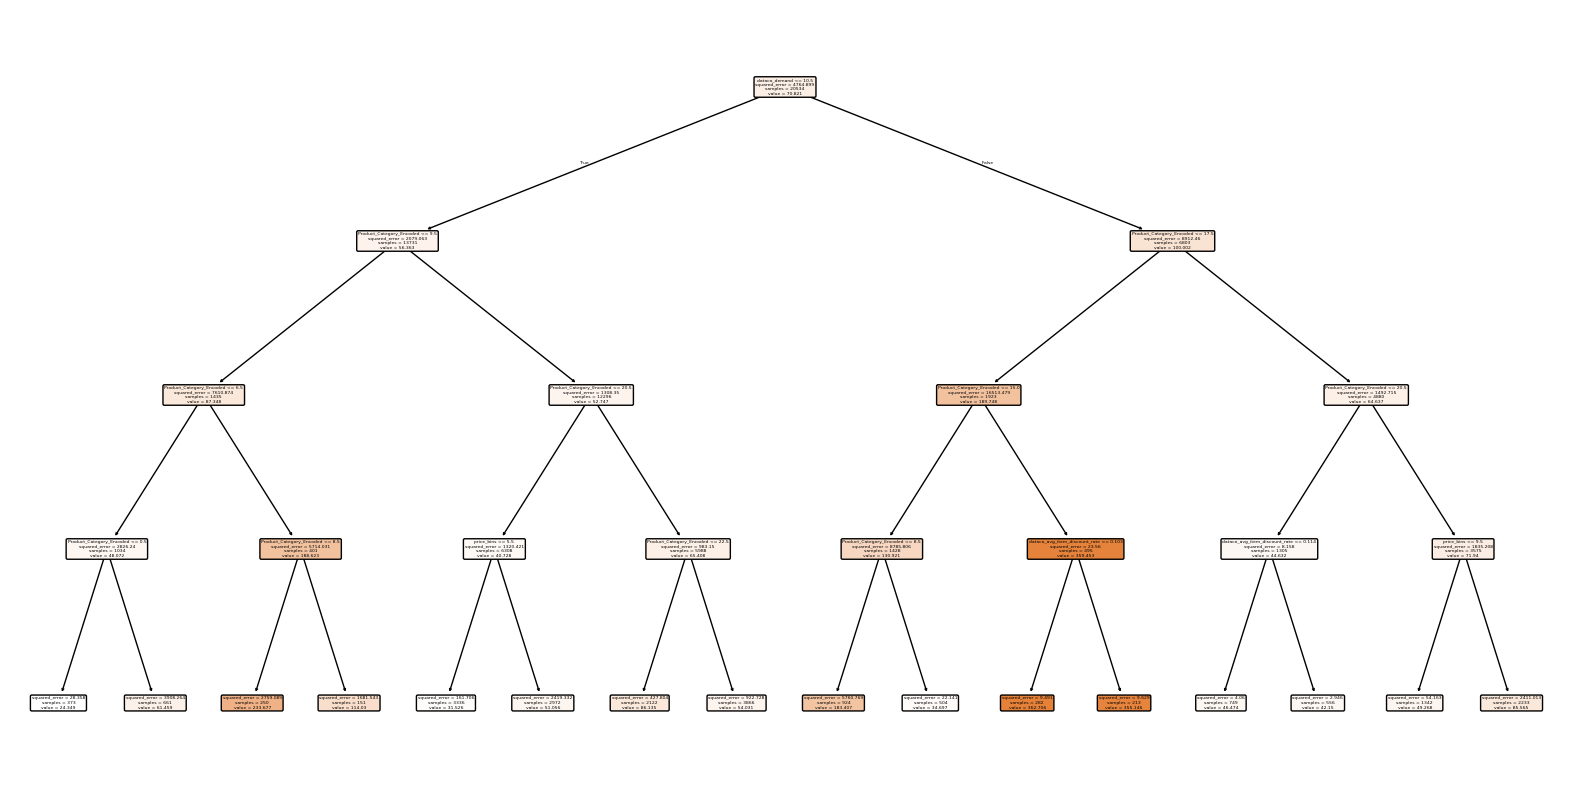

In [21]:
# Assuming 'model' is your trained decision tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed for better readability
plot_tree(
    sklearn_model,
    feature_names=X_train.columns,  # Use the column names from your training set
    class_names=True,               # If it's a classifier, you can show class names
    filled=True,                    # Color nodes to show majority class
    rounded=True                    # Rounded boxes for nodes
)
plt.show()

In [22]:
X_test.columns

Index(['price_bins', 'dataco_avg_item_discount_rate', 'dataco_demand',
       'olist_product_demand', 'olist_price_before_discount',
       'olist_avg_discount_rate', 'Product_Category_Encoded',
       'Seasonality_Holiday - Christmas', 'Seasonality_Holiday - Cyber Monday',
       'Seasonality_Regular', 'Seasonality_Seasonal - Back to School',
       'Seasonality_Seasonal - Summer Sales', 'price_elasticity_Elastic',
       'price_elasticity_Inelastic'],
      dtype='object')

In [23]:
# Set random seed for reproducibility
random.seed(42)

# Define ranges for each column
test_ranges = {
    'price_bins': np.arange(0, 20, 1),
    'dataco_avg_item_discount_rate': np.arange(0.02, 0.1, 0.01),
    'dataco_demand': np.arange(100, 1000, 100),
    'olist_product_demand': np.arange(100, 1000, 100),
    'olist_price_before_discount': np.arange(10, 800, 50),
    'olist_avg_discount_rate': np.arange(0.02, 0.1, 0.01),
    'Product_Category_Encoded': np.arange(0, 50, 1),
    'Seasonality_Holiday - Christmas': [0, 1],
    'Seasonality_Holiday - Cyber Monday': [0, 1],
    'Seasonality_Regular': [0, 1],
    'Seasonality_Seasonal - Back to School': [0, 1],
    'Seasonality_Seasonal - Summer Sales': [0, 1],
    'price_elasticity_Elastic': [0, 1],
    'price_elasticity_Inelastic': [0, 1]
}

# Generate 10 random test cases
test_cases = []
for _ in range(10):
    test_case = {feature: random.choice(values) for feature, values in test_ranges.items()}
    test_cases.append(test_case)

# Convert to DataFrame
test_df = pd.DataFrame(test_cases)

# Example: Making predictions using these test cases
# Assuming 'model' is your trained decision tree model
predictions = sklearn_model.predict(test_df)

# Add predictions to the DataFrame
test_df['Predicted_Price'] = predictions

# Display the test cases with predictions
test_df


,price_bins,dataco_avg_item_discount_rate,dataco_demand,olist_product_demand,olist_price_before_discount,olist_avg_discount_rate,Product_Category_Encoded,Seasonality_Holiday - Christmas,Seasonality_Holiday - Cyber Monday,Seasonality_Regular,Seasonality_Seasonal - Back to School,Seasonality_Seasonal - Summer Sales,price_elasticity_Elastic,price_elasticity_Inelastic,Predicted_Price
0,3,0.02,500,400,360,0.04,47,0,0,1,0,0,0,0,49.267827
1,7,0.02,900,400,660,0.05,28,1,0,0,1,1,1,0,49.267827
2,6,0.07,200,200,610,0.03,22,1,1,0,1,0,1,0,49.267827
3,17,0.06,600,400,110,0.02,42,0,1,0,0,0,1,1,85.565465
4,14,0.07,300,600,560,0.05,42,1,0,0,0,0,1,1,85.565465
5,8,0.05,600,100,360,0.02,20,1,1,0,0,1,0,1,46.474201
6,12,0.09,300,500,210,0.05,47,1,1,1,1,0,0,1,85.565465
7,2,0.02,200,300,260,0.08,38,0,1,1,1,1,0,0,49.267827
8,17,0.06,600,200,460,0.08,10,1,0,1,0,0,1,0,34.696691
9,4,0.07,300,900,10,0.07,31,0,0,1,1,0,0,0,49.267827


In [24]:
test_df.to_csv(os.path.join(pricing_results_dir, "pricing_for_product_categories.csv"), index=False)